In [1]:
#Data Handling and Preprocessing Libraries
import pandas as pd
import numpy as np
import os
from pathlib import Path
#Image Processing Library
import cv2
#Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
#Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras .optimizers import SGD
#Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
# System Utilities
import gc

import warnings
warnings.filterwarnings('ignore')

In [19]:
class OralCancerDataset:
    def __init__(self, image_dir, labels_file, img_size=(224, 224)):
        self.image_dir = image_dir
        self.img_size = img_size
        self.df = pd.read_csv(labels_file)
        self.label_encoder = LabelEncoder()
        # Convert numeric labels to strings if they're numbers
        self.df['label_number'] = self.df['label_number'].astype(str)
        self.df['label_encoded'] = self.label_encoder.fit_transform(self.df['label_number'])
        
        # Store class names as strings
        self.class_names = [str(cls) for cls in self.label_encoder.classes_]
    
    def create_data_generators(self, batch_size=16):
        """Create train, validation, and test data generators instead of loading all data into memory"""
        # Split dataframe indices instead of actual data
        train_val_idx, test_idx = train_test_split(
            np.arange(len(self.df)),
            test_size=0.2,
            random_state=42,
            stratify=self.df['label_encoded']
        )
        
        train_idx, val_idx = train_test_split(
            train_val_idx,
            test_size=0.25,
            random_state=42,
            stratify=self.df.iloc[train_val_idx]['label_encoded']
        )
        
        # Create generators
        train_generator = DataGenerator(
            self.df.iloc[train_idx],
            self.image_dir,
            self.img_size,
            batch_size=batch_size
        )
        
        validation_generator = DataGenerator(
            self.df.iloc[val_idx],
            self.image_dir,
            self.img_size,
            batch_size=batch_size
        )
        
        test_generator = DataGenerator(
            self.df.iloc[test_idx],
            self.image_dir,
            self.img_size,
            batch_size=batch_size
        )
        
        return train_generator, validation_generator, test_generator

class DataGenerator(Sequence):
    def __init__(self, dataframe, image_dir, img_size, batch_size=32):
        self.df = dataframe
        self.image_dir = image_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.indices = np.arange(len(self.df))
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        # Initialize batch arrays
        X = np.zeros((len(batch_indices), *self.img_size, 3), dtype=np.float32)
        y = np.zeros(len(batch_indices), dtype=np.int32)
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = os.path.join(self.image_dir, row['path'])
            img = self._preprocess_image(img_path)
            if img is not None:
                X[i] = img
                y[i] = row['label_encoded']
        
        return X, y
    
    def _preprocess_image(self, image_path):
        img = cv2.imread(image_path)
        if img is None:
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size)
        return img.astype(np.float32) / 255.0

In [20]:
IMAGE_DIR = r"E:\NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data\NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data\patch\images"
LABELS_FILE = r"E:\NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data\NDB-UFES An oral cancer and leukoplakia dataset composed of histopathological images and patient data\patch\sabpatch_parsed_folders.csv"
dataset = OralCancerDataset(IMAGE_DIR, LABELS_FILE)
train_generator, validation_generator, test_generator = dataset.create_data_generators(batch_size=16)

In [22]:
# Model Definition
class OralCancerModel:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.model = self._build_model(num_classes)
        
    def _build_model(self, num_classes):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        return model
    
    def validate_data(self, X_train, y_train, X_test, y_test):
        """Validate input data shapes and types."""
        # Check shapes
        if len(X_train.shape) != 4 or X_train.shape[1:] != (224, 224, 3):
            raise ValueError(f"Expected X_train shape (N, 224, 224, 3), got {X_train.shape}")
        if len(X_test.shape) != 4 or X_test.shape[1:] != (224, 224, 3):
            raise ValueError(f"Expected X_test shape (N, 224, 224, 3), got {X_test.shape}")
            
        # Check labels
        if len(np.unique(y_train)) != self.num_classes:
            raise ValueError(f"Number of unique classes in y_train ({len(np.unique(y_train))}) doesn't match num_classes ({self.num_classes})")
        if len(np.unique(y_test)) != self.num_classes:
            raise ValueError(f"Number of unique classes in y_test ({len(np.unique(y_test))}) doesn't match num_classes ({self.num_classes})")
    
    def model_compile(self, train_generator, validation_generator, epochs=50):
        # Validate input data
        X_train, y_train = next(iter(train_generator))
        self.validate_data(X_train, y_train, X_train, y_train)
        
        # Print shapes for debugging
        print("Training data shapes:")
        print(f"X_train: {X_train.shape}")
        print(f"y_train: {y_train.shape}")
        
        # Model compilation
        self.model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']  # Simplified metrics
        )
        
        # Training the model
        history = self.model.fit(
            train_generator,
            validation_data=validation_generator,  # Add validation data here
            epochs=epochs,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True
                ),
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.2,
                    patience=3,
                    min_lr=1e-6
                )
            ],
            verbose=1  # Ensure verbose is set to see training progress
        )
        return history

    def model_fit(self, test_generator):
        # Validate input data
        X_test, y_test = next(iter(test_generator))
        self.validate_data(X_test, y_test, X_test, y_test)
        
        # Print shapes for debugging
        print("Testing data shapes:")
        print(f"X_test: {X_test.shape}")
        print(f"y_test: {y_test.shape}")
        
        # Testing the model
        results = self.model.evaluate(
            test_generator,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True
                ),
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.2,
                    patience=3,
                    min_lr=1e-6
                )
            ]
        )
        return results

def configure_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(f"Memory growth must be set before GPUs have been initialized: {e}")

def clear_session():
    tf.keras.backend.clear_session()
    gc.collect()

In [26]:
configure_gpu()
model = OralCancerModel(num_classes=len(dataset.class_names))
history = model.model_compile(train_generator, validation_generator, epochs=50)
results = model.model_fit(test_generator)
clear_session()
print("Test Results:", results)

Training data shapes:
X_train: (16, 224, 224, 3)
y_train: (16,)
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.3845 - loss: 1.7503 - val_accuracy: 0.1873 - val_loss: 1.9636 - learning_rate: 1.0000e-04
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.4596 - loss: 1.4816 - val_accuracy: 0.1873 - val_loss: 2.0627 - learning_rate: 1.0000e-04
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 135s 947ms/step - accuracy: 0.4512 - loss: 1.4290 - val_accuracy: 0.2404 - val_loss: 1.5218 - learning_rate: 1.0000e-04
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.4913 - loss: 1.3516 - val_accuracy: 0.3599 - val_loss: 1.2347 - learning_rate: 1.0000e-04
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.5069 - loss: 1.2759 - val_accuracy: 0.5272 - val_loss: 0.9649 - learning_rate: 1.0000e-04
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.5299 - loss: 1.2309 - val_accuracy: 0.5100 - val_loss: 1.0136 - learning_rate: 1.

In [12]:
#Visualization Class
class Visualizer:
    @staticmethod
    def plot_training_history(history):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        ax1.plot(history.history['accuracy'], label='Training')
        ax1.plot(history.history['val_accuracy'], label='Validation')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        ax2.plot(history.history['loss'], label='Training')
        ax2.plot(history.history['val_loss'], label='Validation')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, classes):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes,
                    yticklabels=classes)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        

KeyError: 'val_accuracy'

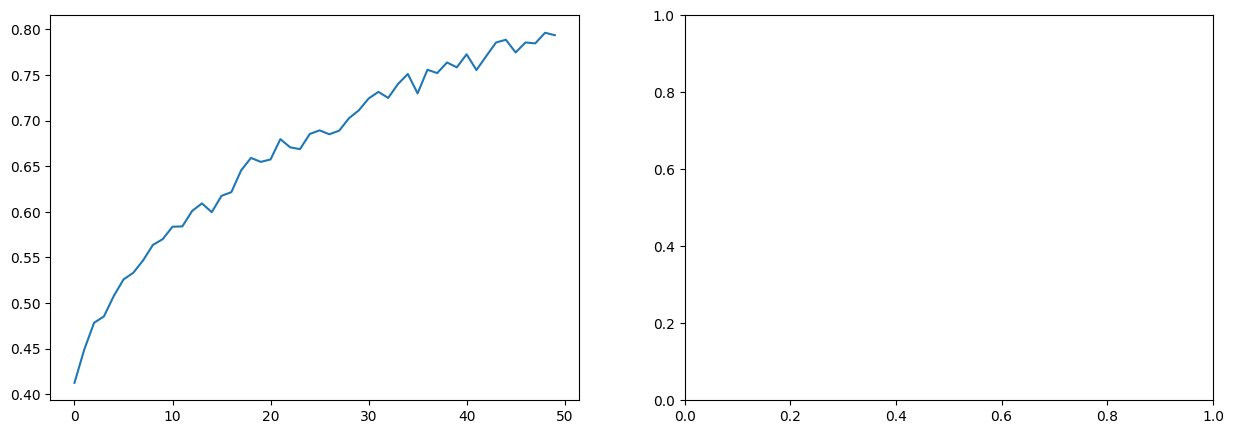

In [13]:
visualizer = Visualizer()
visualizer.plot_training_history(history)

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.44      0.46       142
           1       0.66      0.67      0.67       225
           2       0.67      0.68      0.67       386

    accuracy                           0.63       753
   macro avg       0.60      0.60      0.60       753
weighted avg       0.63      0.63      0.63       753



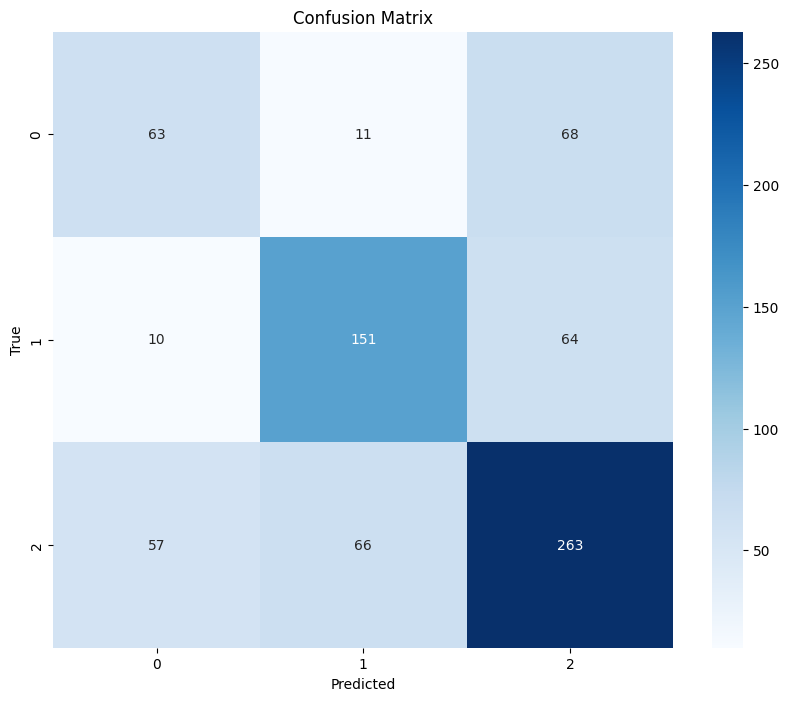

Test Accuracy: 0.6335


In [23]:
def evaluate_model(model, test_generator, class_names):
    """Evaluates the trained model on the test set and generates performance metrics."""
    
    y_true = []
    y_pred = []

    for i in range(len(test_generator)):
        X_batch, y_batch = test_generator[i]  # Fetch batch

        if X_batch.shape[0] == 0:  # Skip empty batches
            continue
        
        preds = model.model.predict(X_batch, verbose=0)  # Predict probabilities
        y_pred.extend(np.argmax(preds, axis=1))  # Convert to class labels
        y_true.extend(y_batch)

    # Convert lists to NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Ensure arrays are not empty
    if len(y_true) == 0 or len(y_pred) == 0:
        print("Error: No valid predictions were made. Check your test dataset.")
        return

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Plot confusion matrix
    Visualizer.plot_confusion_matrix(y_true, y_pred, class_names)

    # Compute accuracy
    accuracy = np.mean(y_true == y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

# Run the evaluation
evaluate_model(model, test_generator, dataset.class_names)

model.model.save('oral_cancer_model.h5')